In [17]:
!pip install geopy tqdm geopandas

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from tqdm import tqdm
import time
#import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Overview
- The csv below has over 1180 schools that have athletics programs in the US
- The features ae the name, school_website, division, conference, tuition in state and out of state, gpa, and enrollment size.
- The goal for this analysis is to determine whether the location of a college can affect the other features shownin the csv.

#DISCLAIMER
- This only analyzes schools that are in the NCAA and some from the NAIA

#Data Understanding
- name: Names of colleges
- school_website: The college's athletic website
- division: The athletic division each college is in
- conference: The athletic conference each college is in
- tuition in state and out of state: cost to attend the college
- gpa: the avg gpa in order to get accetped to th college
- enrollment: Amount of people attending the school yearly

In [19]:
df = pd.read_csv('complete_college_data.csv')
df.head()

,id,name,school_website,division,location,conference,source_url,tuition_in_state,tuition_out_of_state,gpa,enrollment,logo_link,logos
0,1011,central christian college,https://ccctigers.com,NAIA,"mcpherson, ks",sooner athletic conference,NaN,20650,20650,3.24,259.0,NaN,binary data
1,1133,arizona state university,https://thesundevils.com,I,"tempe, az",big 12,https://www.ncaa.com/schools/arizona-st,12223,33139,3.54,64778.0,NaN,binary data
2,1032,harris-stowe state university,https://hornetsathletics.com,NAIA,"st. louis, mo",american midwest conference,NaN,6058,10690,3.04,1163.0,NaN,binary data
3,1080,the college of idaho,https://yoteathletics.com,NAIA,"caldwell, id",cascade collegiate conference,NaN,34630,34630,3.66,1055.0,NaN,NaN
4,385,mount olive college,https://umotrojans.com,II,"mount olive, nc",carolinas,https://www.ncaa.com/schools/mount-olive,23591,23591,2.85,2000.0,https://www.ncaa.com/sites/default/files/image...,binary data


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1187 non-null   int64  
 1   name                  1187 non-null   object 
 2   school_website        1187 non-null   object 
 3   division              1187 non-null   object 
 4   location              1186 non-null   object 
 5   conference            1176 non-null   object 
 6   source_url            1049 non-null   object 
 7   tuition_in_state      1187 non-null   object 
 8   tuition_out_of_state  1187 non-null   int64  
 9   gpa                   1187 non-null   float64
 10  enrollment            1184 non-null   float64
 11  logo_link             999 non-null    object 
 12  logos                 1148 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 120.7+ KB


#We are using nomnation geocoder to convert each schools city and state into precise longitude and latitude coordiinates

In [21]:
# Initialize geocoder
geolocator = Nominatim(user_agent="college_mapper")

In [22]:
# Function to get latitude and longitude
def geocode_location(location):
    try:
        time.sleep(1)  # avoid overloading the API
        loc = geolocator.geocode(location + ", USA")
        if loc:
            return pd.Series([loc.latitude, loc.longitude])
    except:
        return pd.Series([None, None])
    return pd.Series([None, None])

In [23]:
# Create lat/lng columns
tqdm.pandas()
df[['latitude', 'longitude']] = df['location'].progress_apply(geocode_location)

100%|██████████| 1187/1187 [25:08<00:00,  1.27s/it]


In [24]:
df = df.dropna(subset=['latitude', 'longitude'])


#Below is an example of how to vizualize this using matplotlib and seaborn but we're going to take a look at the one using plotly since its interactive


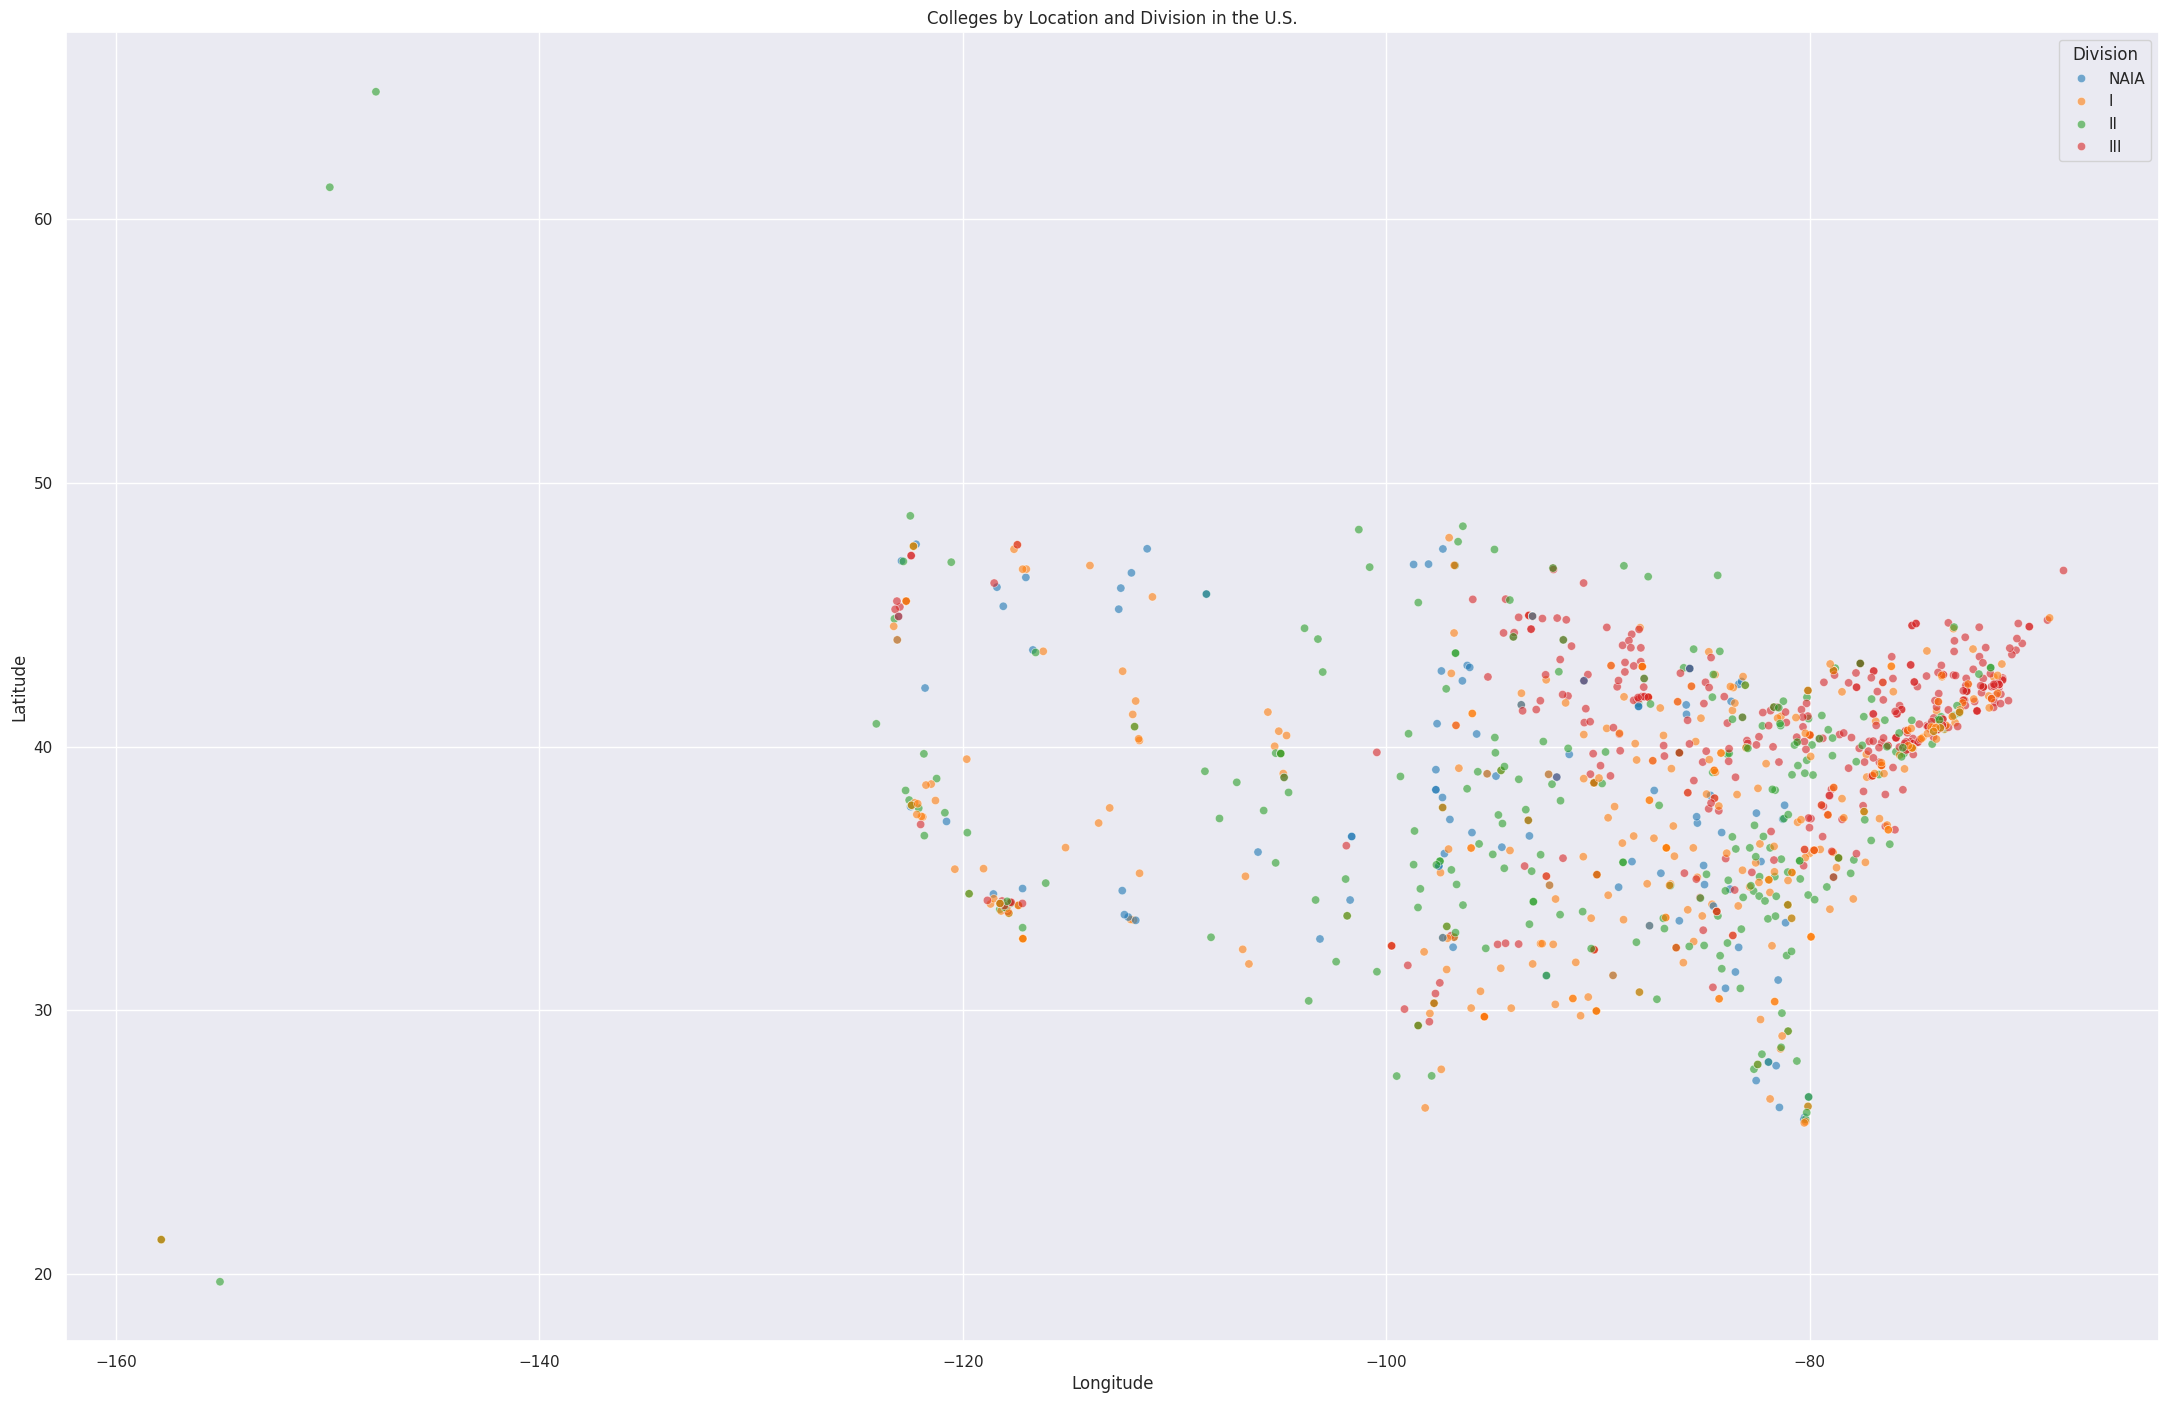

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(27, 17))
sns.set(style="darkgrid")

# Draw scatter plot of locations
sns.scatterplot(x="longitude", y="latitude", data=df, hue="division", palette="tab10", alpha=0.6)

plt.title("Colleges by Location and Division in the U.S.")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Division")
plt.show()

- Below shows all colleges that are in the US that are seperated by division.
- Clear indication that there are much more division 3 schools in the north compared to the south
- Insights:
  - Larger amount of schools north which is why there are more division 3 schools.
  - Southern states focus more on athletics than academics which is why there are more division 1 schools.

In [26]:
import plotly.express as px

# Drop rows with missing coordinates or division
plot_df = df.dropna(subset=['latitude', 'longitude', 'division'])

fig = px.scatter_mapbox(
    plot_df,
    lat="latitude",
    lon="longitude",
    color="division",              # Use division as color category
    hover_name="name",
    hover_data={
        "division": True,
        "location": True,
        "gpa": True,
        "enrollment": True,
        "tuition_out_of_state": True,
        "latitude": False,
        "longitude": False
    },
    zoom=3,
    height=800,
    title="Interactive Map: Colleges by Division Across the U.S.",
)

fig.update_layout(mapbox_style="carto-positron")  # Same tile style as contextily
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()



#Vizualization of tuition differences in the US by colleges with athletics programs
#Insights:
  - Much higher tuition cost for colleges in the north east, california is an expeception because the avg tuition there is very high.
  - The southern states have slightly lower tuition cost.
  - This may also be because there is a higher frequency of colleges in the north  than there is in the south.

In [27]:
import plotly.express as px

# Clean data (remove missing lat/lon or tuition)
plot_df = df.dropna(subset=["latitude", "longitude", "tuition_out_of_state"])

fig = px.scatter_geo(
    plot_df,
    lat="latitude",
    lon="longitude",
    color="tuition_out_of_state",
    hover_name="name",
    hover_data={
        "division": True,
        "location": True,
        "tuition_out_of_state": True,
        "gpa": True,
        "enrollment": True,
        "latitude": False,
        "longitude": False
    },
    color_continuous_scale="Viridis",
    scope="usa",
    title="Interactive Map: U.S. Colleges Colored by Out-of-State Tuition",
    height=800
)

fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    geo=dict(
        showland=True,
        landcolor="lightgray",
        lakecolor="white",
        showlakes=True,
        projection_type="albers usa"
    )
)

fig.show()


Text(0.5, 1.0, 'Count of Colleges by State')

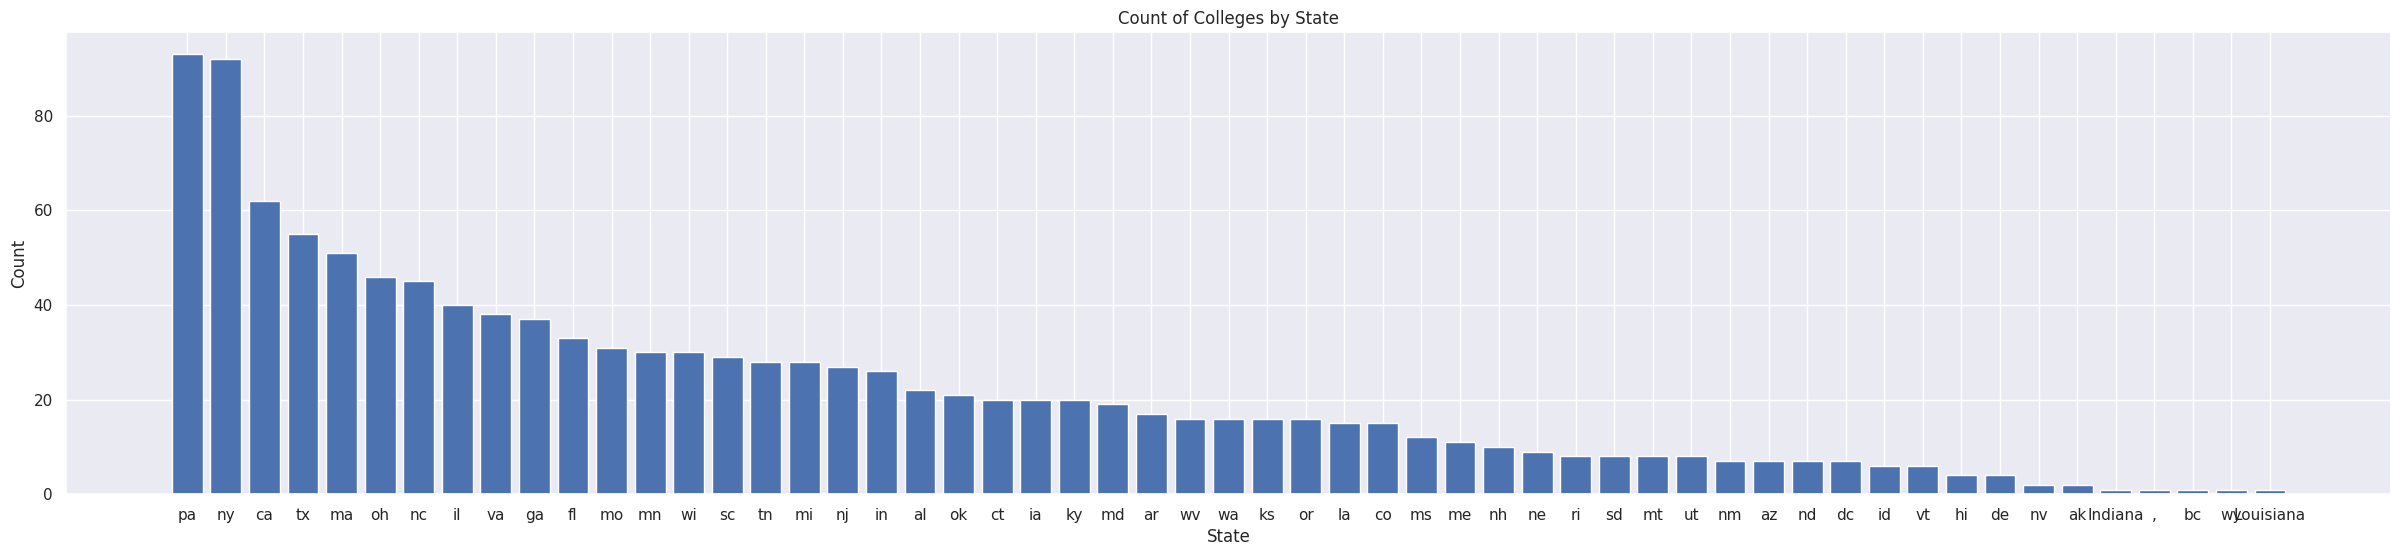

In [33]:
#counting the amount of colleges in each state
state_counts = df['location'].str.split(', ').str[-1].value_counts()
state_counts = state_counts.reset_index()
state_counts.columns = ['state', 'count']
state_counts

#histogram with this dataframe using matplotlib
plt.figure(figsize=(30, 6))
plt.bar(state_counts['state'], state_counts['count'])
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Count of Colleges by State')


#Conclusion
- Higher tuition rates and location do have a correlation with each other
- There are multiple factors that come into play:
  - amount of colleges in north east states, according to the histogram above northern states overall have more schools compared to southern states.
  - tax differences in each state
  - more private institutions up north which usually have higher tuition rates.

- There are more Division III (D3) schools in the northern U.S.
- Here's why:
  - Higher Concentration of Private Colleges – Many D3 schools are private institutions, and the Northeast and Midwest have a long history of private liberal arts colleges that prioritize academics over athletics.
  - Population Density & College Tradition – The northern states have a higher concentration of colleges overall, especially in states like Massachusetts, Pennsylvania, and New York, which have strong traditions of small, academically focused schools.
  - Athletic Philosophy – D3 schools emphasize a balance between academics and athletics, and many northern institutions align with this philosophy rather than offering athletic scholarships like D1 and D2 schools.
